In [1]:
from ROOT import TFile, TTree, TCanvas, TH1D, TH2D
from Scripts.DataFormat import Particle, Lepton, Jet, get_leptons, get_jets
from ROOT import EnableImplicitMT
EnableImplicitMT(20)

Welcome to JupyROOT 6.22/08


In [2]:
# Get Fake Rate
f_muon = TFile.Open("/root/workspace/HcToWA/MetaInfo/2017/fakerate_muon.root")
f_electron = TFile.Open("/root/workspace/HcToWA/MetaInfo/2017/fakerate_electron.root")
h_muon = f_muon.Get("h_fakerate")
h_electron = f_electron.Get("h_fakerate")


In [3]:
h_obs = TH1D("obs", "", 200, 0., 200.)
h_exp = TH1D("exp", "", 200, 0., 200.)
h_exp_up = TH1D("exp_up", "", 200, 0., 200.)
h_exp_down = TH1D("exp_down", "", 200, 0., 200.)

In [4]:
rtfile = TFile.Open("/root/workspace/HcToWA/Samples/Selector/2017/Skim1E2Mu__/Selector_SkimTree_SS2lOR3l_TTLL_powheg.root")
Observed = 0. 
Expected = 0.
Expected_up = 0.
Expected_down = 0.
for evt in rtfile.Events:
    muons, electrons = get_leptons(evt)
    jets, bjets = get_jets(evt)
    METv = Particle(evt.METv_Pt, evt.METv_eta, evt.METv_phi, 0.)

    # safe pt cut
    passDblMuCut = muons[0].Pt() > 20. and muons[0].Pt() > 10.
    passEMuCut = muons[0].Pt() > 25. or electrons[0].Pt() > 25.
    if not (passDblMuCut or passEMuCut):
        continue
    
    # get fake weight
    w_fake = -1.
    w_fake_up = -1.
    w_fake_down = -1. 
    n_tightmu = 0
    n_tightele = 0
    for muon in muons:
        # ptcorr and abseta
        ptCorr = muon.Pt()*(1.+max(muon.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 69.)
        absEta = abs(muon.Eta())
        fr = h_muon.GetBinContent(h_muon.FindBin(ptCorr, absEta))
        fr_up = fr + h_muon.GetBinError(h_muon.FindBin(ptCorr, absEta))
        #fr_up = fr*1.3
        fr_down = fr - h_muon.GetBinError(h_muon.FindBin(ptCorr, absEta))
        if muon.isTight:
            n_tightmu += 1
        else:
            w_fake *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    for electron in electrons:
        # ptcorr and abseta
        ptCorr = electron.Pt()*(1.+max(electron.MiniIso()-0.1, 0.))
        ptCorr = min(ptCorr, 69.)
        absEta = abs(electron.Eta())
        fr = h_electron.GetBinContent(h_electron.FindBin(ptCorr, absEta))
        fr_up = fr + h_electron.GetBinError(h_electron.FindBin(ptCorr, absEta))
        #fr_up = fr*1.3
        fr_down = fr - h_electron.GetBinError(h_electron.FindBin(ptCorr, absEta))
        if electron.isTight:
            n_tightele += 1
        else:
            w_fake  *= -fr/(1-fr)
            w_fake_up *= -fr_up/(1-fr_up)
            w_fake_down *= -fr_down/(1-fr_down)
    
    # event selection
    # 2 prompt letpons, 1 fake lepton
    n_prompt = 0
    n_fake = 0
    for muon in muons:
        if muon.LepType() < 0:
            n_fake += 1
        elif muon.LepType() == 1:
            n_prompt += 1
        else:
            pass
    for ele in electrons:
        if ele.LepType() < 0:
            n_fake += 1
        elif ele.LepType() == 1:
            n_prompt += 1
        else:
            pass
    if not (n_prompt == 2 and n_fake == 1):
        continue

    weight = evt.genWeight*evt.trigLumi
    # observed
    if n_tightmu == 2 and n_tightele == 1:
        Observed += weight
        h_obs.Fill(electrons[0].Pt(), weight)
    # expected
    else:
        Expected += weight*w_fake
        Expected_up += weight*w_fake_up
        Expected_down += weight*w_fake_down
        h_exp.Fill(electrons[0].Pt(), weight*w_fake)
        h_exp_up.Fill(electrons[0].Pt(), weight*w_fake_up)
        h_exp_down.Fill(electrons[0].Pt(), weight*w_fake_down)

In [5]:
print(f"Observed: {Observed}")
print(f"Expected: {Expected}")
print(f"Expected Up: {Expected_up}")
print(f"Expected Down: {Expected_down}")

Observed: 872.8993443645625
Expected: 809.3098108359135
Expected Up: 1068.4186796341924
Expected Down: 591.0415649600312


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


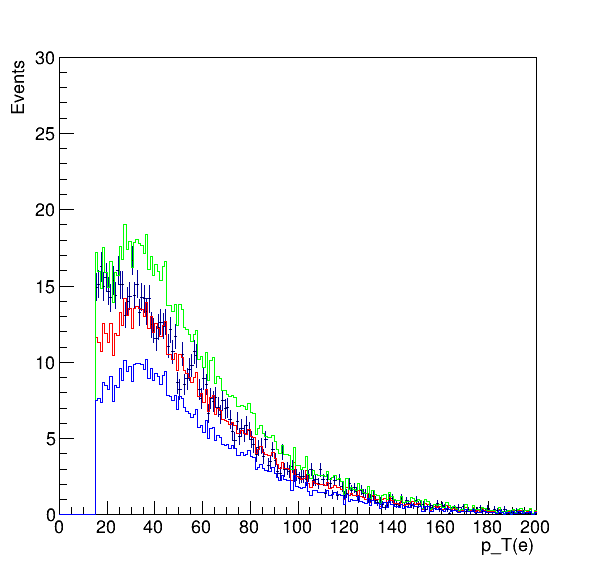

In [8]:
cvs = TCanvas("cvs", "csv", 600, 600)
cvs.cd()
h_obs.SetStats(0)
h_obs.GetXaxis().SetTitle("p_T(e)")
h_obs.GetYaxis().SetTitle("Events")
h_obs.GetYaxis().SetRangeUser(0, 30)
h_exp.SetLineColor(2)
h_exp_up.SetLineColor(3)
h_exp_down.SetLineColor(4)
h_obs.Draw()
h_exp.Draw("hist&same")
h_exp_up.Draw("hist&same")
h_exp_down.Draw("hist&same")
cvs.Draw()